In [ ]:
import pandas as pd
import numpy as np

result_df = pd.read_csv('NeighDemo_ActuallyUseThisOne.csv')


In [ ]:
from sklearn.preprocessing import StandardScaler

result_df['Neighborhood'] = result_df['Neighborhood'].str.strip()

numerical_data = result_df.iloc[:, 4:]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)
scaled_data = np.nan_to_num(scaled_data, nan=0.0)

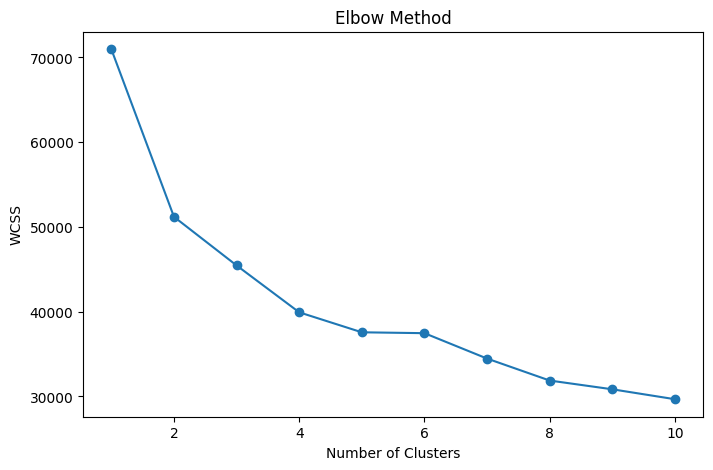

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS for different cluster numbers
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [ ]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

result_df["Cluster"] = clusters

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

def find_closest_neighborhood(city1, neighborhood1, city2, df):
    city1 = city1.strip().lower()
    neighborhood1 = neighborhood1.strip().lower()
    city2 = city2.strip().lower()

    # Normalize data in the DataFrame
    df["City_normalized"] = df["City"].str.strip().str.lower()
    df["Neighborhood_normalized"] = df["Neighborhood"].str.strip().str.lower()

    city1_data = df[df["City_normalized"] == city1]
    if city1_data.empty:
        raise ValueError(f"No data found for city '{city1}'.")

    # Set NaN values to 0 for city1_data
    city1_data = city1_data.fillna(0)

    # Filter data for City #2
    city2_data = df[df["City_normalized"] == city2]
    if city2_data.empty:
        raise ValueError(f"No data found for city '{city2}'.")

    # Set NaN values to 0 for city2_data
    city2_data = city2_data.fillna(0)

    # Get data for the specified neighborhood in City #1
    neighborhood1_data = city1_data[city1_data["Neighborhood_normalized"] == neighborhood1].iloc[:, 4:]
    if neighborhood1_data.empty:
        raise ValueError(f"No data found for neighborhood '{neighborhood1}' in city '{city1}'.")

    # Extract numerical data for neighborhoods in City #2
    city2_numerical = city2_data.iloc[:, 4:]
    if city2_numerical.empty:
        raise ValueError(f"City '{city2}' has no valid numerical data.")

    # Compute Euclidean distances
    distances = euclidean_distances(neighborhood1_data, city2_numerical)

    # Find the index of the closest neighborhood
    closest_idx = np.argmin(distances)
    return city2_data.iloc[closest_idx]["Neighborhood"]

closest = find_closest_neighborhood("New York City", "Bushwick and Williamsburg", "San Fransisco", result_df)
knn_neighborhood = closest
print("Closest neighborhood:", closest)

Closest neighborhood: Nob Hill


In [ ]:
def find_closest_neighborhood_cluster(city1, neighborhood1, city2, df, optimal_k):
    city1 = city1.strip().lower()
    neighborhood1 = neighborhood1.strip().lower()
    city2 = city2.strip().lower()

    # Normalize DataFrame columns
    df["City_normalized"] = df["City"].str.strip().str.lower()
    df["Neighborhood_normalized"] = df["Neighborhood"].str.strip().str.lower()

    # Filter data for City #1
    city1_data = df[df["City_normalized"] == city1]
    if city1_data.empty:
        raise ValueError(f"No data found for city '{city1}'.")

    # Set NaN values to 0 for city1_data
    city1_data = city1_data.fillna(0)

    # Filter data for City #2
    city2_data = df[df["City_normalized"] == city2]
    if city2_data.empty:
        raise ValueError(f"No data found for city '{city2}'.")

    # Set NaN values to 0 for city2_data
    city2_data = city2_data.fillna(0)

    # Get data for the specified neighborhood in City #1
    neighborhood1_data = city1_data[city1_data["Neighborhood_normalized"] == neighborhood1].iloc[:, 4:]
    if neighborhood1_data.empty:
        raise ValueError(f"No data found for neighborhood '{neighborhood1}' in city '{city1}'.")

    # Extract cluster label for the neighborhood in City #1
    neighborhood1_cluster = city1_data[city1_data["Neighborhood_normalized"] == neighborhood1]["Cluster"].iloc[0]

    # Filter neighborhoods in City #2 that are in the same cluster as neighborhood1
    city2_in_same_cluster = city2_data[city2_data["Cluster"] == neighborhood1_cluster]

    if not city2_in_same_cluster.empty:
        # Compute Euclidean distances within the same cluster
        city2_numerical_same_cluster = city2_in_same_cluster.iloc[:, 4:]
        distances = euclidean_distances(neighborhood1_data, city2_numerical_same_cluster)

        # Find the index of the closest neighborhood within the same cluster
        closest_idx = np.argmin(distances)
        return city2_in_same_cluster.iloc[closest_idx]["Neighborhood"]
    else:
        # If no neighborhoods are in the same cluster, use KNN without clusters
        city2_numerical = city2_data.iloc[:, 4:]
        distances = euclidean_distances(neighborhood1_data, city2_numerical)

        # Find the index of the closest neighborhood in City #2
        closest_idx = np.argmin(distances)
        return city2_data.iloc[closest_idx]["Neighborhood"]


optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
result_df["Cluster"] = clusters

closest = find_closest_neighborhood_cluster("New York City", "Bushwick and Williamsburg", "San Fransisco", result_df, optimal_k)
demo_neighborhood = closest
print("Closest neighborhood:", closest)

Closest neighborhood: Nob Hill


In [ ]:
vibe_neighborhood = closest

In [ ]:
def hard_vote(neigh1, neigh2, neigh3):
  if (neigh1 == neigh2 == neigh3):
    return neigh1
  elif (neigh2 == neigh3):
    return neigh2
  elif (neigh1 == neigh2):
    return neigh1
  elif (neigh1 == neigh3):
    return neigh1
  else:
    return neigh1


city_known = "New York City"
neighborhood_known = "Upper West Side"
city_new = "Boston"
optimal_k = 5
knn_neighborhood = find_closest_neighborhood(city_known, neighborhood_known, city_new, result_df)
demo_neighborhood = find_closest_neighborhood_cluster("New York City", "Bushwick and Williamsburg", "San Fransisco", result_df, optimal_k)
vibe_neighborhood = "To be done"

final_neighborhood = hard_vote(knn_neighborhood,demo_neighborhood,vibe_neighborhood)
print("The most similar neighborhood is:", final_neighborhood)